<a href="https://colab.research.google.com/github/Kyalo-oss/Movie-lens-recommendation-system-/blob/main/Movielens_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'movielens:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F108335%2F258538%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240604%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240604T153623Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9080a4071bec0153cbca2ebec73faf8dc724d367e1cdfb3b19bae70b2cb6678e3e4a331d6a35e744932078b257756c3509ee5423b0ce0ec1762754a7eb06789497f372d884f4b5fd476e0dd26e1c0f04d62af354dc9214f6f0e558877ee0728c8e3be7c2fedd9e1d4aba04f04c72c6f486c1ca6f4564d6132ea40555b1f958cc3cd7ba371a2042667953483c84cbec2b351cf967953b7dc9fd8e921eecb529bd46a7ed480e5ae73102f362b7a17026a4c80e1cfe29eccd120127d2d6a214c2f558182c1c1a554663a74d8efb389eada89c0e6971ed7f629d30e98283d20512bf044e51fa6ebdc029cba862fb1eac924d55b11f5d2a6faab1e2af9974eb69904f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 6109178 bytes downloaded
Downloaded and uncompressed: movielens
Data source import complete.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movielens/ratings.dat
/kaggle/input/movielens/users.dat
/kaggle/input/movielens/movies.dat


# MOVIELENS RECOMMENDATION SYSTEM

Movie recommendation systems are essential in the current digital era because people looking for personalized recommendations may become overwhelmed by the sheer amount of available movie content. ⁤⁤This project seeks to create a strong recommendation system by utilizing the MovieLens dataset. ⁤⁤We try to find patterns and trends by carefully prepping and examining the dataset for insights. ⁤⁤Our goal is to develop a dynamic recommendation system that not only makes movie selection easier but also improves user experiences by offering personalized suggestions, boosting content discovery, and encouraging engagement in the varied world of cinema through the application of collaborative filtering techniques like matrix factorization or nearest neighbors methods.

In [5]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 1.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357257 sha256=57751ddc1f845c5be48dc7d1083aab1e72fcb524048d8605d49459ca683ae07f
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [6]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from surprise.model_selection import train_test_split
from surprise import Dataset, Reader, SVD, accuracy



# DATA PREPARATION AND EXPLORATION


In [7]:
# Loading movies.dat
movies = pd.read_csv('/kaggle/input/movielens/movies.dat', sep='::', names=['MovieID', 'Title', 'Genres'], engine='python', encoding='latin1')

print("Movies:")
print(movies.head(10))

# Checking for missing values
print("Movies missing values:")
print(movies.isnull().sum())




Movies:
   MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy
5        6                         Heat (1995)         Action|Crime|Thriller
6        7                      Sabrina (1995)                Comedy|Romance
7        8                 Tom and Huck (1995)          Adventure|Children's
8        9                 Sudden Death (1995)                        Action
9       10                    GoldenEye (1995)     Action|Adventure|Thriller
Movies missing values:
MovieID    0
Title      0
Genres     0
dtype: int64


In [8]:
# loading Users.dat file
users = pd.read_csv('/kaggle/input/movielens/users.dat', sep='::', names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python', encoding='latin1')

print("Users:")
print(users.head(10))

print("Users missing values:")
print(users.isna().sum())

Users:
   UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117
3       4      M   45           7    02460
4       5      M   25          20    55455
5       6      F   50           9    55117
6       7      M   35           1    06810
7       8      M   25          12    11413
8       9      M   25          17    61614
9      10      F   35           1    95370
Users missing values:
UserID        0
Gender        0
Age           0
Occupation    0
Zip-code      0
dtype: int64


In [9]:
# Dropping Occupation and Zip-code columns
users.drop(['Occupation', 'Zip-code'],axis=1, inplace=True)


In [13]:
# loading Ratings.dat file
ratings = pd.read_csv('/kaggle/input/movielens/ratings.dat', sep='::', names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python', encoding='latin1')

print("Ratings:")
print(ratings.head(10))

print("ratings missing values:")
print(ratings.isna().sum())

Ratings:
   UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291
5       1     1197       3  978302268
6       1     1287       5  978302039
7       1     2804       5  978300719
8       1      594       4  978302268
9       1      919       4  978301368
ratings missing values:
UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64


In [14]:
#Dropping column Timestamp
ratings = ratings.drop("Timestamp", axis=1)


In [15]:
ratings.head(10)

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
5,1,1197,3
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4


# DATA ANALYSIS AND VISUALIZATION

# Analysis of User Engagement and Content Popularity


We explore the trends in user interaction and popular content on our platform in this section. Through the analysis of interaction frequency that is, the quantity of user-provided ratings we are able to derive important insights about user behavior and trends in content consumption.

**User Engagement Analysis**

First, we determine which users are the most engaged with our platform. Through this, we can identify the most active users—those who routinely watch a lot of movies—regardless of the ratings given. Comprehending the engagement patterns of users is imperative for proficient user segmentation, focused marketing campaigns, and the provision of customized suggestions based on individual preferences.

**Content Popularity Assessment**

⁤Furthermore, we explore the popularity of movies within our platform, irrespective of their ratings. ⁤⁤By analyzing the frequency of movie views and interactions, we identify the movies that garner the highest levels of viewership. ⁤⁤This insight is invaluable for content acquisition strategies, licensing negotiations, and decisions regarding future content production or acquisition. ⁤In this case, since we don't have the number of times each user has watched a movie, we use ratings count as the number each user has watched the movie.

This are crucial steps towards optimizing platform performance, enhancing user experience, and refining content curation algorithms to better align with user preferences and viewing habits


In [16]:

# Merge User and Ratings data on 'UserID'
user_ratings = ratings.merge(users, on='UserID')

# Display the merged DataFrame
user_ratings.head(10)

,UserID,MovieID,Rating,Gender,Age
0,1,1193,5,F,1
1,1,661,3,F,1
2,1,914,3,F,1
3,1,3408,4,F,1
4,1,2355,5,F,1
5,1,1197,3,F,1
6,1,1287,5,F,1
7,1,2804,5,F,1
8,1,594,4,F,1
9,1,919,4,F,1


First and Foremost we will start by showing the total number of users on the platform, followed by a breakdown by gender

Number of users by Gender: 
Males:  753769
Females:  246440
Total : 1000209


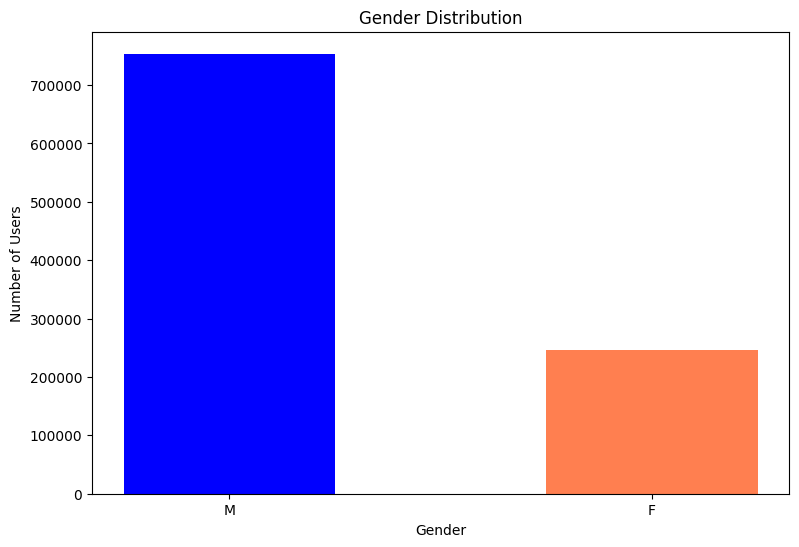

In [17]:
# Gender Distribution

gender_counts = user_ratings['Gender'].value_counts()

Male = gender_counts.get('M', 0)
Female = gender_counts.get('F', 0)

print("Number of users by Gender: ")
print("Males: ", Male)
print("Females: ", Female)
print("Total :", Male + Female)

# Colors for Gender bars
colors = ['blue' if gender == 'M' else 'coral' for gender in gender_counts.index]

# Gender Plot

plt.figure(figsize=(9,6))
plt.bar(gender_counts.index, gender_counts.values, width=0.5 ,color=colors)
plt.xlabel("Gender")
plt.ylabel("Number of Users")
plt.title("Gender Distribution")
plt.show()

In [18]:
#Top 10 users with the highest number of ratings

No_of_ratings = user_ratings['UserID'].value_counts()

top_10_users_ratings = No_of_ratings.head(10)

print("Top 10 Users with the highest number of ratings:")
print(top_10_users_ratings)

Top 10 Users with the highest number of ratings:
UserID
4169    2314
1680    1850
4277    1743
1941    1595
1181    1521
889     1518
3618    1344
2063    1323
1150    1302
1015    1286
Name: count, dtype: int64


In [19]:
# Merge Movies and ratings data on "MovieID"

movie_ratings = movies.merge(ratings, on="MovieID")

movie_ratings.head(10)

,MovieID,Title,Genres,UserID,Rating
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5
5,1,Toy Story (1995),Animation|Children's|Comedy,18,4
6,1,Toy Story (1995),Animation|Children's|Comedy,19,5
7,1,Toy Story (1995),Animation|Children's|Comedy,21,3
8,1,Toy Story (1995),Animation|Children's|Comedy,23,4
9,1,Toy Story (1995),Animation|Children's|Comedy,26,3


In [20]:
# Top 10 Movies with the highest number of ratings

no_of_movie_ratings = movie_ratings[['MovieID','Title']].value_counts()

print("Movies with the hightest No of ratings: ")
print(no_of_movie_ratings.head(10))

Movies with the hightest No of ratings: 
MovieID  Title                                                
2858     American Beauty (1999)                                   3428
260      Star Wars: Episode IV - A New Hope (1977)                2991
1196     Star Wars: Episode V - The Empire Strikes Back (1980)    2990
1210     Star Wars: Episode VI - Return of the Jedi (1983)        2883
480      Jurassic Park (1993)                                     2672
2028     Saving Private Ryan (1998)                               2653
589      Terminator 2: Judgment Day (1991)                        2649
2571     Matrix, The (1999)                                       2590
1270     Back to the Future (1985)                                2583
593      Silence of the Lambs, The (1991)                         2578
Name: count, dtype: int64


In [21]:
no_of_movie_ratings.describe()

count    3706.000000
mean      269.889099
std       384.047838
min         1.000000
25%        33.000000
50%       123.500000
75%       350.000000
max      3428.000000
Name: count, dtype: float64

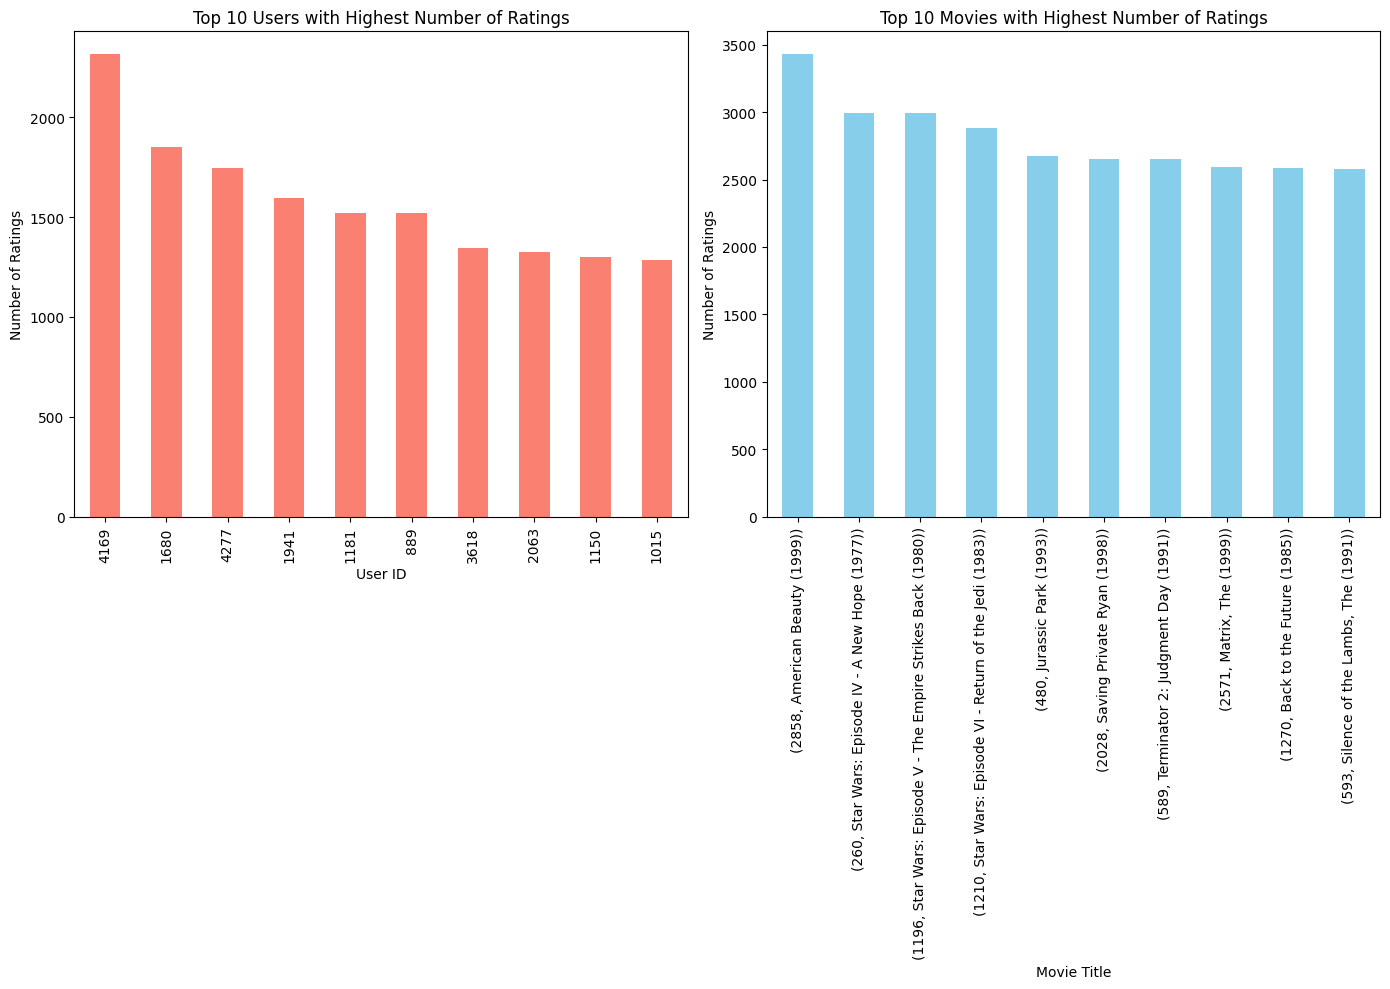

In [22]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 10))

# Plot top 10 users with highest number of ratings
No_of_ratings.head(10).plot(kind='bar', color='salmon', ax=ax[0])
ax[0].set_title('Top 10 Users with Highest Number of Ratings')
ax[0].set_xlabel('User ID')
ax[0].set_ylabel('Number of Ratings')


# Plot top 10 movies with highest number of ratings
no_of_movie_ratings.head(10).plot(kind='bar', color='skyblue', ax=ax[1])
ax[1].set_title('Top 10 Movies with Highest Number of Ratings')
ax[1].set_xlabel('Movie Title')
ax[1].set_ylabel('Number of Ratings')
ax[1].tick_params(axis='x', rotation=90)

# Display plots
plt.tight_layout()
plt.show()

# Top 10 Users who rated the most movies

From the visualizations above we can see that the top 10 User ID's have rated over a 1000 movies. There are several insights that we can get from this:

- **Influence of Highly Active Users:** Highly active users might have an influence on other users through their ratings and reviews. Their engagement can help drive recommendations and influence the viewing choices of less active users.

- **Usage Patterns:** The data can also indicate different usage patterns. For instance, these top users might spend more time on the platform and might be more receptive to new features, premium content, or personalized recommendations.

- **Content Consumption Trends:** These top users can provide valuable insights into content consumption trends. Understanding what these highly engaged users are watching and rating can help in identifying popular genres or types of content that might appeal to other users.

Normally, we consider that the top 10 are outliers cause the description stats states otherwise as 75% of the users,have rated 350 movies or fewer. This further supports the idea that the majority of users are not as highly engaged as the top 10 users. 50% of the users have rated 123.5 movies which indicates a central tendency towards lower engagement levels compared to the highly active top 10 users. 25% of users have rated 33 movies or fewer. This suggests a significant portion of the user base has relatively low engagement.

# Top 10 Movies with the Highest Number of Ratings

This listing gives you a good idea about the number of movies watched as well as their level of engagement on this platform. Although the ratings may range from 1 to 5, the massive number of ratings indicates a high level of engagement and the interest in these titles among the users.

**Top Rated Movies:**

- American Beauty (1999) is the most popular or viewed movie in the online cinema with 3428 ratings.

- A greater number of people might watch movies like Star Wars, Jurassic Park, Saving Private Ryan, and The Matrix, which are some of the most popular films.

- The list predominantly features well-known and critically acclaimed movies from various genres and time periods.

**Genres and Eras:**

The movies span different genres such as drama (American Beauty), sci-fi (Star Wars, The Matrix), action (Terminator 2), and thriller (Silence of the Lambs).

The films also cover a range of release years, from the late 1970s (Star Wars: Episode IV) to the late 1990s (The Matrix).

**Consistent Popularity:**

The high number of ratings indicates sustained popularity over time, suggesting these movies have a lasting appeal and are frequently viewed and rated by new users.

In [23]:
# Genre with the most Ratings

Genres_rating = movies['Genres'].value_counts()

Genres_rating.head(50)


Genres
Drama                           843
Comedy                          521
Horror                          178
Comedy|Drama                    162
Comedy|Romance                  142
Drama|Romance                   134
Documentary                     116
Thriller                        101
Action                           65
Drama|Thriller                   63
Action|Thriller                  48
Children's|Comedy                47
Crime|Drama                      44
Drama|War                        43
Romance                          40
Action|Drama                     39
Animation|Children's             35
Comedy|Drama|Romance             34
Western                          33
Horror|Sci-Fi                    33
Horror|Thriller                  32
Comedy|Horror                    31
Adventure|Children's             30
Action|Sci-Fi                    28
Sci-Fi                           27
Crime                            26
Action|Adventure                 25
Action|Comedy        

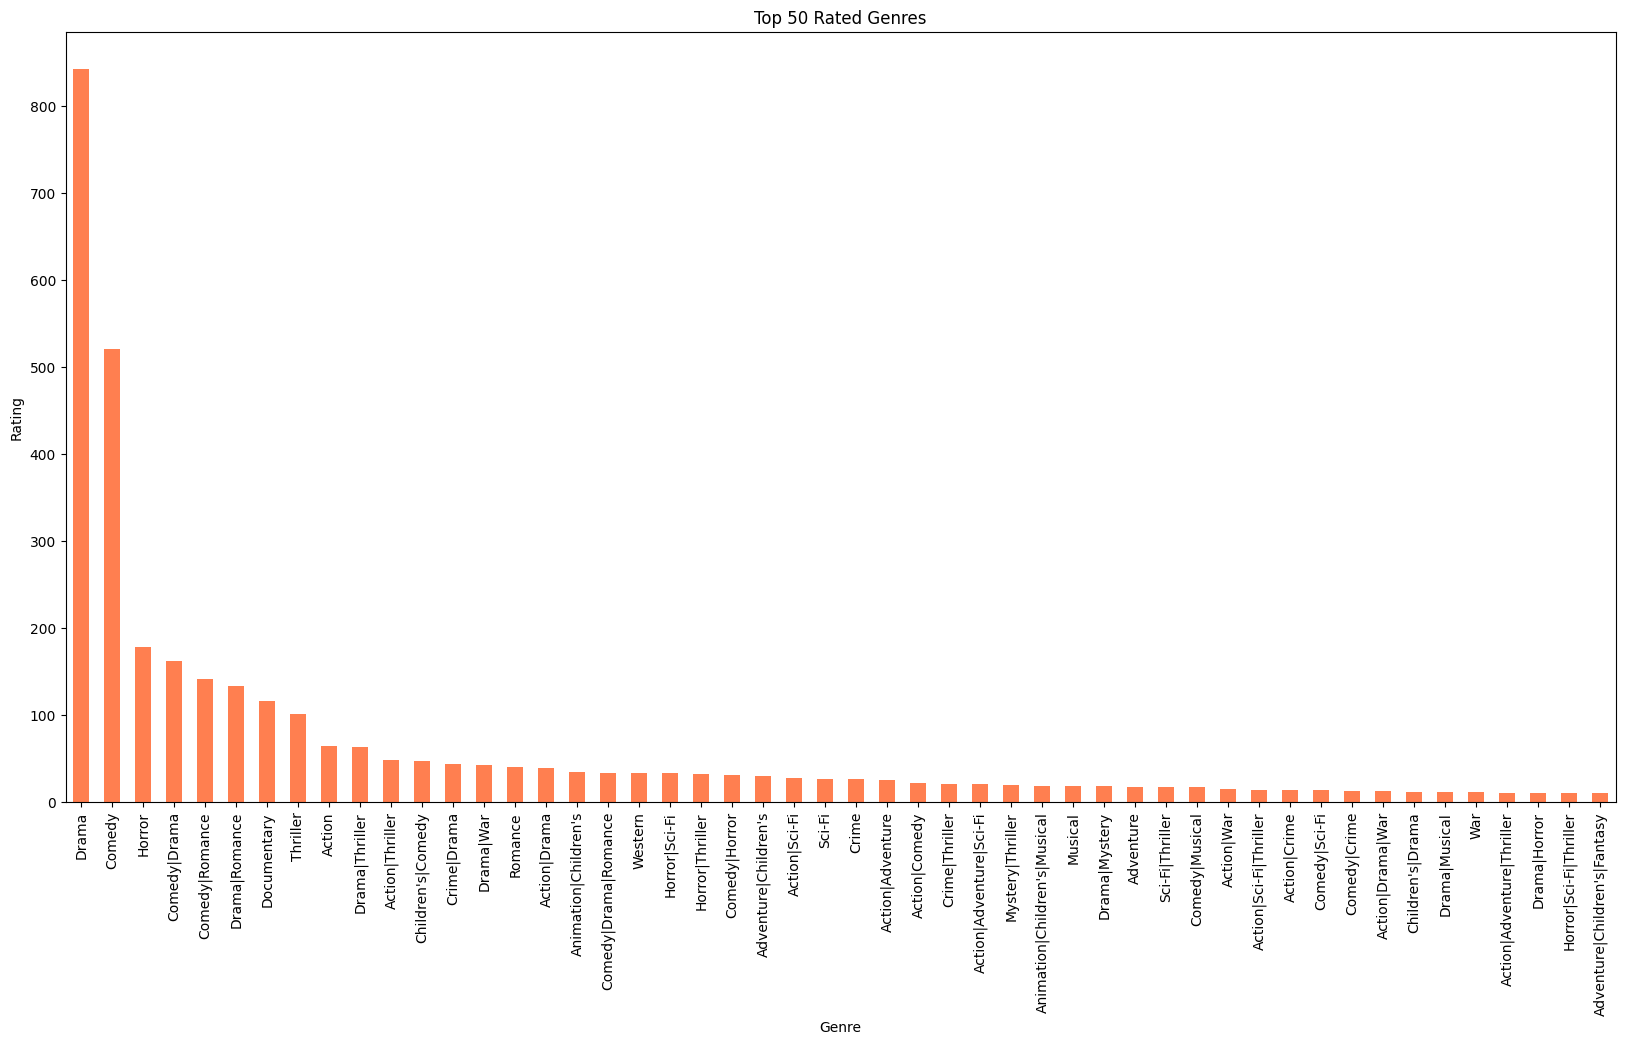

In [24]:
# Plot Top 50 rated Genres

plt.figure(figsize=(20, 10))
Genres_rating.head(50).plot(kind='bar', color='coral')
plt.xlabel('Genre')
plt.ylabel('Rating')
plt.title('Top 50 Rated Genres')
plt.show()

**This visualization shows genres which are rated the most.**

In [25]:
movies = pd.DataFrame(movies)

# Merge User_ratings with movies dataframe based on 'MovieID'
Master_data = user_ratings.merge(movies, on='MovieID')

# Display the final merged DataFrame
Master_data

,UserID,MovieID,Rating,Gender,Age,Title,Genres
0,1,1193,5,F,1,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,M,56,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,M,25,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,M,25,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,M,50,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...,...,...
1000204,5949,2198,5,M,18,Modulations (1998),Documentary
1000205,5675,2703,3,M,35,Broken Vessels (1998),Drama
1000206,5780,2845,1,M,18,White Boys (1999),Drama
1000207,5851,3607,5,F,18,One Little Indian (1973),Comedy|Drama|Western


In [26]:
Master_data.describe()

,UserID,MovieID,Rating,Age
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,2.973831e+01
std,1.728413e+03,1.096041e+03,1.117102e+00,1.175198e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.506000e+03,1.030000e+03,3.000000e+00,2.500000e+01
50%,3.070000e+03,1.835000e+03,4.000000e+00,2.500000e+01
75%,4.476000e+03,2.770000e+03,4.000000e+00,3.500000e+01
max,6.040000e+03,3.952000e+03,5.000000e+00,5.600000e+01


In [27]:
Master_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 7 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   UserID   1000209 non-null  int64 
 1   MovieID  1000209 non-null  int64 
 2   Rating   1000209 non-null  int64 
 3   Gender   1000209 non-null  object
 4   Age      1000209 non-null  int64 
 5   Title    1000209 non-null  object
 6   Genres   1000209 non-null  object
dtypes: int64(4), object(3)
memory usage: 53.4+ MB


In [28]:
# Creating column AgeGroup for the model

bins = [0, 10, 20, 30, 40, 50, 60, float('inf')]
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60+']
Master_data['AgeGroup'] = pd.cut(Master_data['Age'], bins=bins, labels=labels, right=False)

# Print the categorized age groups
print(Master_data[['UserID', 'Age', 'AgeGroup']])



         UserID  Age AgeGroup
0             1    1      0-9
1             2   56    50-59
2            12   25    20-29
3            15   25    20-29
4            17   50    50-59
...         ...  ...      ...
1000204    5949   18    10-19
1000205    5675   35    30-39
1000206    5780   18    10-19
1000207    5851   18    10-19
1000208    5938   25    20-29

[1000209 rows x 3 columns]


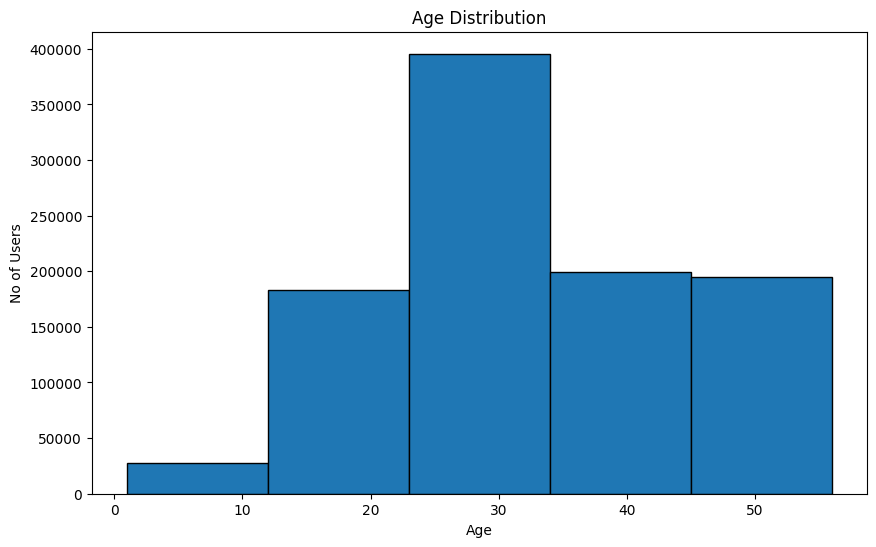

In [29]:
# Distribution of Age

plt.figure(figsize=(10,6))
plt.hist(Master_data['Age'], bins=5, edgecolor='k')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('No of Users')
plt.show()

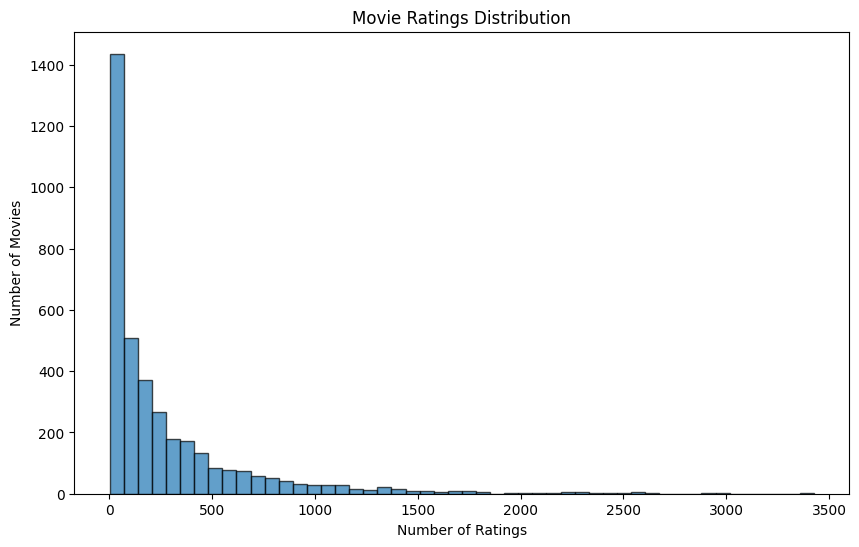

In [30]:
# Ratings distribution

ratings_count = Master_data.groupby('MovieID')['Rating'].count()

plt.figure(figsize=(10, 6))
plt.hist(ratings_count, bins=50, edgecolor='k', alpha=0.7)
plt.title('Movie Ratings Distribution')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.show()



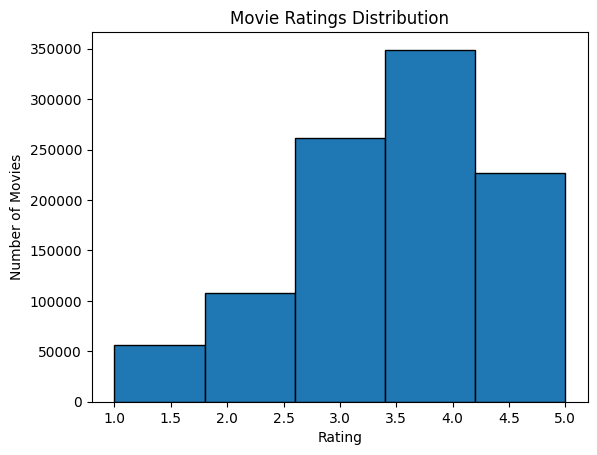

In [31]:
# Create a histogram of movie ratings
plt.hist(Master_data['Rating'], bins=5, range=(1, 5), edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Number of Movies')
plt.title('Movie Ratings Distribution')
plt.show()

In [32]:
# Filter the rows with a rating of 5
highly_rated_movies = Master_data[Master_data['Rating'] == 5]

# Display the movies with a rating of 5
highly_rated_movies

,UserID,MovieID,Rating,Gender,Age,Title,Genres,AgeGroup
0,1,1193,5,F,1,One Flew Over the Cuckoo's Nest (1975),Drama,0-9
1,2,1193,5,M,56,One Flew Over the Cuckoo's Nest (1975),Drama,50-59
4,17,1193,5,M,50,One Flew Over the Cuckoo's Nest (1975),Drama,50-59
6,19,1193,5,M,1,One Flew Over the Cuckoo's Nest (1975),Drama,0-9
7,24,1193,5,F,25,One Flew Over the Cuckoo's Nest (1975),Drama,20-29
...,...,...,...,...,...,...,...,...
1000189,5532,404,5,M,25,Brother Minister: The Assassination of Malcolm...,Documentary,20-29
1000195,5313,3656,5,M,56,Lured (1947),Crime,50-59
1000199,5334,3382,5,F,56,Song of Freedom (1936),Drama,50-59
1000204,5949,2198,5,M,18,Modulations (1998),Documentary,10-19


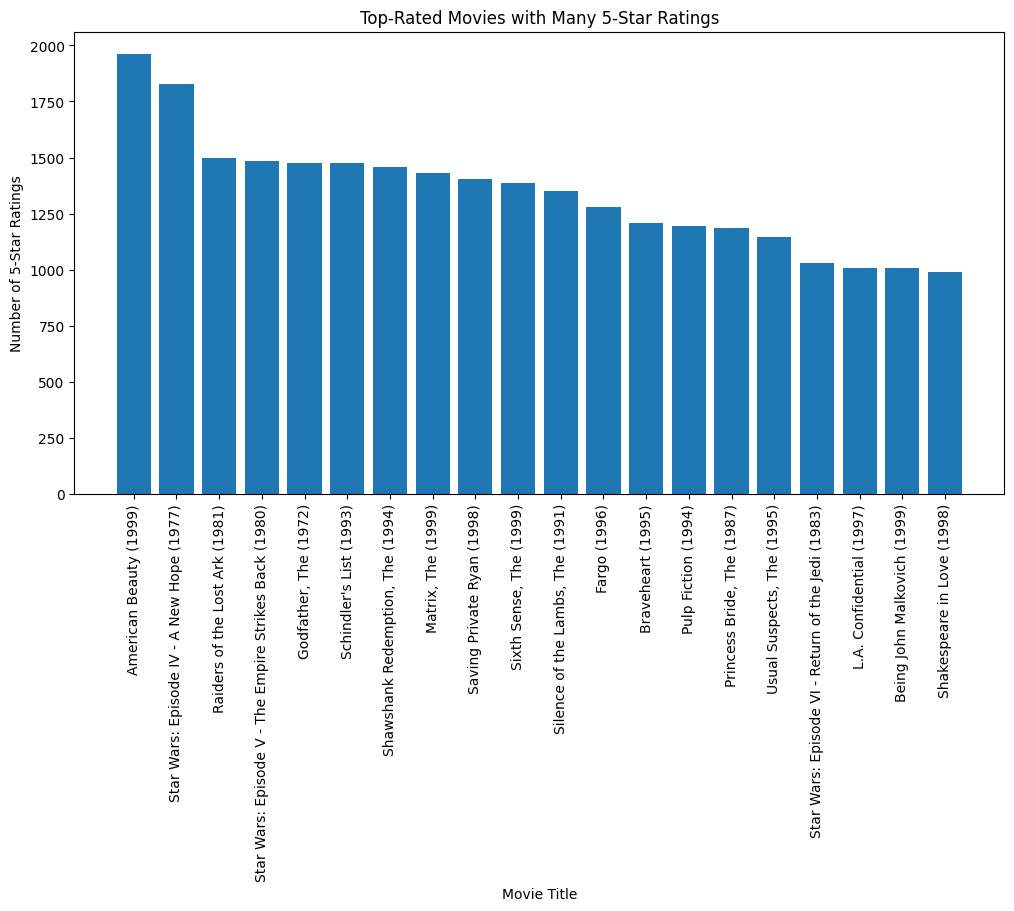

In [33]:
# Group by movie title and count 5-star ratings
movie_ratings = Master_data[Master_data['Rating'] == 5].groupby('Title')['Rating'].count().reset_index()

# Movies with the highest ratings
top_rated_movies = movie_ratings.sort_values(by='Rating', ascending=False)

# bar plot for the top-rated movies
plt.figure(figsize=(12, 6))
plt.bar(top_rated_movies['Title'][:20], top_rated_movies['Rating'][:20])
plt.xlabel('Movie Title')
plt.ylabel('Number of 5-Star Ratings')
plt.title('Top-Rated Movies with Many 5-Star Ratings')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

In [34]:
# Filter the rows with a rating of 1
low_rated_movies  = Master_data[Master_data['Rating'] == 1]

# Display the movies with a rating of 1
low_rated_movies

,UserID,MovieID,Rating,Gender,Age,Title,Genres,AgeGroup
52,206,1193,1,M,25,One Flew Over the Cuckoo's Nest (1975),Drama,20-29
252,889,1193,1,M,45,One Flew Over the Cuckoo's Nest (1975),Drama,40-49
259,925,1193,1,F,35,One Flew Over the Cuckoo's Nest (1975),Drama,30-39
294,1051,1193,1,F,25,One Flew Over the Cuckoo's Nest (1975),Drama,20-29
311,1111,1193,1,F,50,One Flew Over the Cuckoo's Nest (1975),Drama,50-59
...,...,...,...,...,...,...,...,...
1000162,4486,133,1,M,35,Nueba Yol (1995),Comedy|Drama,30-39
1000186,5944,1868,1,F,18,"Truce, The (1996)",Drama|War,10-19
1000194,5795,591,1,M,25,Tough and Deadly (1995),Action|Drama|Thriller,20-29
1000198,5334,127,1,F,56,"Silence of the Palace, The (Saimt el Qusur) (1...",Drama,50-59


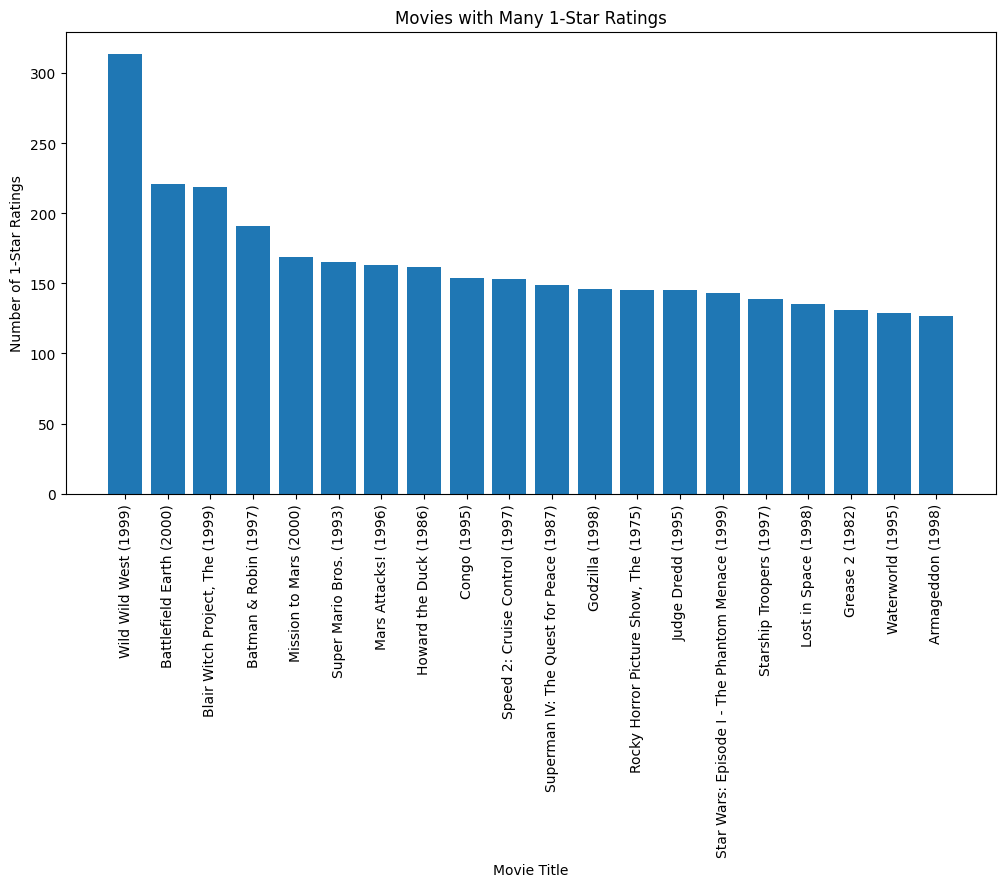

In [35]:

# Grouping by movie title and count the number of ratings
movie_ratings_count = low_rated_movies['Title'].value_counts().reset_index()
movie_ratings_count.columns = ['Title', 'Number of 1-Star Ratings']

# Sorting the movies by the number of 1-star ratings in descending order
top_low_rated_movies = movie_ratings_count.sort_values(by='Number of 1-Star Ratings', ascending=False)


# Create a bar plot for the top low-rated movies
plt.figure(figsize=(12, 6))
plt.bar(top_low_rated_movies['Title'][:20], top_low_rated_movies['Number of 1-Star Ratings'][:20])
plt.xlabel('Movie Title')
plt.ylabel('Number of 1-Star Ratings')
plt.title('Movies with Many 1-Star Ratings')
plt.xticks(rotation=90)
plt.show()


# Collaborative Filterting Model

**Singular Value Decomposition (SVD)**

In [36]:

# Prepare the dataset for Surprise

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(Master_data[['UserID', 'MovieID', 'Rating']], reader)

# Split the data into a training set and a testing set
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Build a collaborative filtering model (SVD)
model = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02)
model.fit(trainset)

# Make predictions on the test set
predictions = model.test(testset)

# Evaluate the model using Root Mean Squared Error (RMSE)

rmse = accuracy.rmse(predictions)
print(f"RMSE: {rmse:.2f}")



#Print Mean Absolute Error (MAE)

mae = accuracy.mae(predictions)
print(f"MAE: {mae:.2f}")

# Get actual ratings and predicted ratings
actual_ratings = [pred.r_ui for pred in predictions]
predicted_ratings = [pred.est for pred in predictions]

# Calculate R-squared
mean_rating = sum(actual_ratings) / len(actual_ratings)
TSS = sum((rating - mean_rating) ** 2 for rating in actual_ratings)
RSS = sum((actual - predicted) ** 2 for actual, predicted in zip(actual_ratings, predicted_ratings))
rsquared = 1 - (RSS / TSS)

print(f"R-squared: {rsquared:.4f}")




# Recommend movies for a specific user
user_id = 5 # Users ID

movies_rated_by_user = Master_data[Master_data['UserID'] == user_id]['MovieID']
movies_not_rated_by_user = Master_data[~Master_data['MovieID'].isin(movies_rated_by_user)]
movies_to_recommend = movies_not_rated_by_user['MovieID'].unique()

user_predictions = [model.predict(user_id, movie_id) for movie_id in movies_to_recommend]

# Sort and filter the top movie recommendations by predicted rating
sorted_predictions = sorted(user_predictions, key=lambda x: x.est, reverse=True)
top_n = 10  # Number of top recommendations to display

# Keep track of recommended movies to ensure they are unique
recommended_movies = set()
top_movie_titles = []

for prediction in sorted_predictions:
    if len(recommended_movies) >= top_n:
        break
    if prediction.iid not in recommended_movies:
        recommended_movies.add(prediction.iid)
        top_movie_titles.append(Master_data[Master_data['MovieID'] == prediction.iid]['Title'].values[0])

print(f"Top {top_n} Movie Recommendations for User {user_id}:\n")
for i, title in enumerate(top_movie_titles):
    print(f"{i + 1}. {title}")

RMSE: 0.8708
RMSE: 0.87
MAE:  0.6846
MAE: 0.68
R-squared: 0.3916
Top 10 Movie Recommendations for User 5:

1. Brazil (1985)
2. Annie Hall (1977)
3. This Is Spinal Tap (1984)
4. Magnolia (1999)
5. Ed Wood (1994)
6. Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)
7. Clockwork Orange, A (1971)
8. Heathers (1989)
9. Roger & Me (1989)
10. Blood Simple (1984)


While the model achieved an RMSE of 0.87 and MAE of 0.69, its performance is considered moderate which is common for recommender systems based on collaborative filtering.